In [1]:
import torch
import numpy as np
import pyvista as pv
import Ofpp
from utils.visualizer import *
pv.set_jupyter_backend('static') 

import sys
import os
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Torch_VFM')
from src.utils.mesh_utils import *
from src.utils.data_utils import get_bc_dict
from src.gauss_green import gaus_green_vfm_mesh
from src.physics.operators import *

dtype = torch.float64

In [3]:
def load_case_mesh(dir, bc_dict):
    vtk_file_reader = pv.POpenFOAMReader(dir)

    # Get Mesh
    mesh = gaus_green_vfm_mesh(vtk_file_reader, dtype = dtype)
    if bc_dict is not None:
        mesh.add_bc_conditions(bc_dict)

    # Get Ground Truth Data
    vtk_file_reader.set_active_time_value(vtk_file_reader.time_values[-1])
    vtk_file_reader.cell_to_point_creation = False
    vtk_file_reader.enable_all_patch_arrays()
    vtk_mesh = vtk_file_reader.read()[0]
    U_gt = torch.tensor(vtk_mesh['U'], dtype = dtype).unsqueeze(0).unsqueeze(0)
    return mesh, vtk_mesh, U_gt

## Cavity Case Validation
- Orthogonal with no Skew
- Solved Purely linear, with no corrections

In [3]:
U_bc_dict = {
            'movingWall':{ "type":'fixedValue', "value":[1,0,0]},
            'fixedWalls':{ "type":'fixedValue', "value":[0,0,0]},  
            'frontAndBack':{ "type":'empty'}    
            }
p_bc_dict = {
    'movingWall':{ "type":'zeroGradient' },
    'fixedWalls':{ "type":'zeroGradient' },  
    'frontAndBack':{ "type":'empty'}    
}
bc_dict = {'U':U_bc_dict, 'p':p_bc_dict}

nu = 0.01

Torch FVM solutions

In [ ]:
dir = r'C:\Users\Noahc\Documents\USYD\tutorial\cavity_sparse\case.foam' # works with branch 8b84c8c3920ded25156e8da0475b22fc2a2253bf
dir = r'C:\Users\Noahc\Documents\USYD\tutorial\cavity_128_simple_from_GNOT\case.foam' 
mesh, vtk_mesh, U_gt =  load_case_mesh(dir, bc_dict)

Calculating face centers and areas for 4160 faces
Corrected 0 misaligned face area vectors
{'max_non_orthogonality': 0.0, 'avg_non_orthogonality': 0.0, 'max_skewness': 4.449557669067511e-15, 'avg_skewness': 1.0024919745583159e-15}
 Found Patch "movingWall" with 32 Faces
 Found Patch "fixedWalls" with 96 Faces
 Found Patch "frontAndBack" with 2176 Faces
Boundary faces indexed: 2304/2176 patches found
Calculating Cell2Cell at Face Linear Interpolation Weights (L2):
  min w:0.5000,               max w:0.5000,               mean w:0.5000


In [5]:
divU_pred, gradU_pred = Divergence_Operator.caclulate(mesh, field=U_gt)
lap_pred = Laplacian_Operator.caclulate(mesh, field=U_gt)*nu

Sample solutions

In [6]:
gradU_gt = torch.tensor(vtk_mesh['grad(U)'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
lapU_gt = torch.tensor(vtk_mesh['lapU'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
divU_gt = torch.tensor(vtk_mesh['divU_phiAll'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)

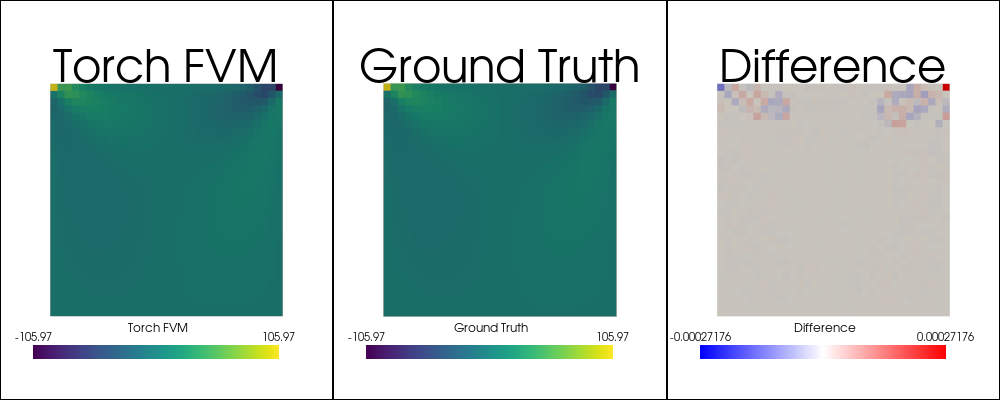

In [7]:
names = ['dudx', 'dudy', 'dvdx', 'dvdy']
#for i, j in enumerate([0,1,3,4]):
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=gradU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = gradU_gt.squeeze(0).squeeze(0).numpy(),
                    )

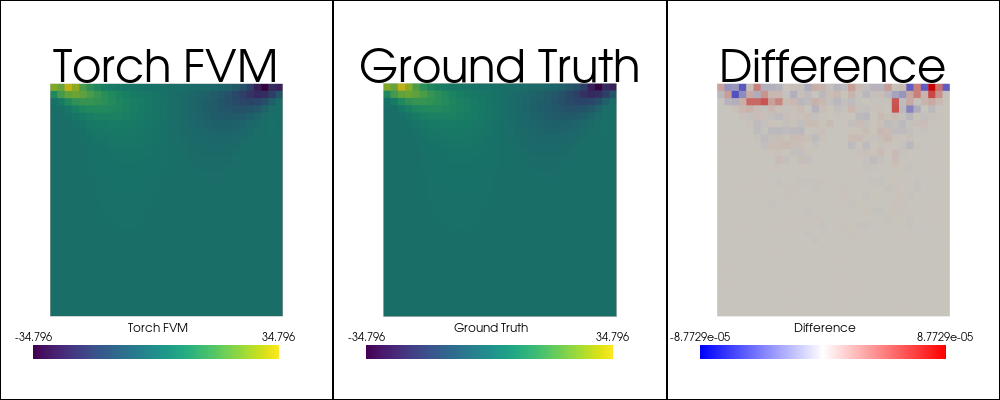

In [8]:
names = ['divU', 'divV']
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=divU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = divU_gt.squeeze(0).squeeze(0).numpy(),
                    )

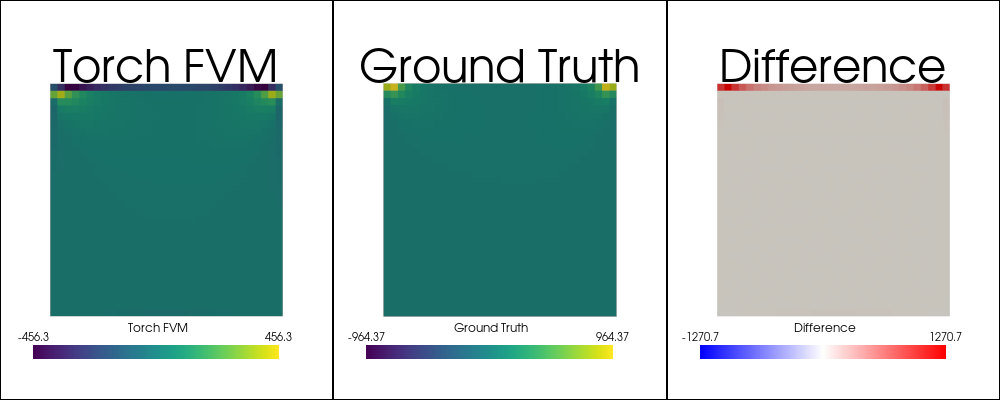

In [9]:
names = ['lapU', 'lapV']
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=lap_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = lapU_gt.squeeze(0).squeeze(0).numpy(),
                    )

## Cylinder Case

In [4]:
from src.utils.data_utils import get_bc_dict # default cylinder bc list

dir = r'C:\Users\Noahc\Downloads\c5_test\case.foam'
mesh, vtk_mesh, U_gt =  load_case_mesh(dir, bc_dict=get_bc_dict())
nu = 0.013333333333333334

resorting to default bc_dict, this line needs to be superseeded
Calculating face centers and areas for 37020 faces
Corrected 0 misaligned face area vectors
{'max_non_orthogonality': 43.433995038442895, 'avg_non_orthogonality': 4.755765077554514, 'max_skewness': 0.19769376516342163, 'avg_skewness': 0.005930359475314617}
 Found Patch "out" with 80 Faces
 Found Patch "sym1" with 100 Faces
 Found Patch "sym2" with 100 Faces
 Found Patch "in" with 80 Faces
 Found Patch "cylinder" with 80 Faces
 Found Patch "back" with 9200 Faces
 Found Patch "front" with 9200 Faces
Boundary faces indexed: 18840/18840 patches found
Calculating Cell2Cell at Face Linear Interpolation Weights (L2):
  min w:0.4621,               max w:0.5837,               mean w:0.5050


In [42]:
divU_pred, gradU_pred = Divergence_Operator.caclulate(mesh, field=U_gt)

mesh._calculate_correction_vectors(method = mesh.correction_method)
lap_pred = Laplacian_Operator.caclulate(mesh, 
                                        field=U_gt, 
                                        correction_method=None)*nu
lap_pred_corrected = Laplacian_Operator.caclulate(mesh, field=U_gt, 
                                                  correction_method=mesh.correction_method,
                                                  gradient_field=gradU_pred
                                                  )*nu

torch.Size([1, 1, 18180, 3]) torch.Size([1, 1, 18180, 3, 3]) torch.Size([1, 1, 9200, 3, 3])
torch.Size([1, 1, 18180, 3, 3]) torch.Size([1, 1, 9200, 3, 3])
out
sym1
sym2
in
cylinder


In [9]:
gradU_gt = torch.tensor(vtk_mesh['grad(U)'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
divU_gt = torch.tensor(vtk_mesh['divU'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
lapU_gt = torch.tensor(vtk_mesh['lapU'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
lapU_gt_corrected = torch.tensor(vtk_mesh['lapU_corrected'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)

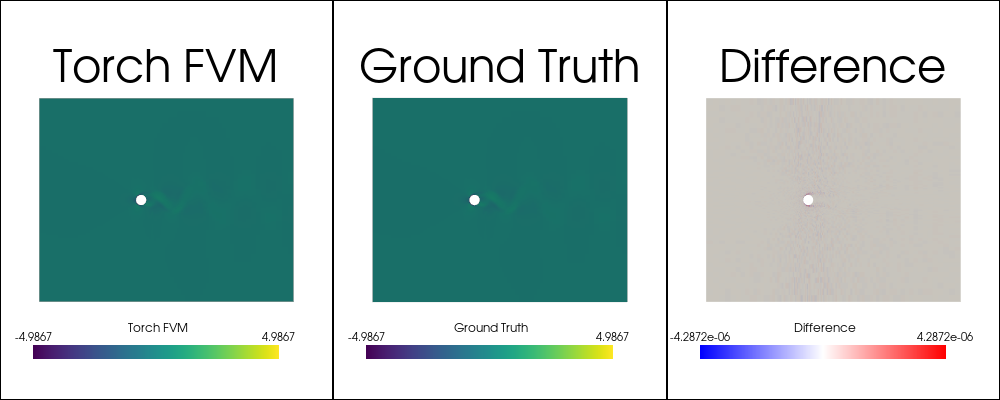

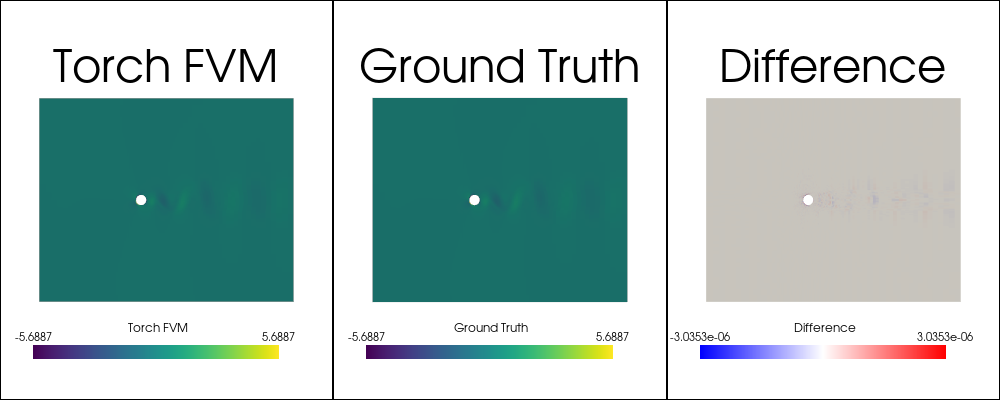

In [43]:
names = ['dudx', 'dudy', 'dvdx', 'dvdy']
#for i, j in enumerate([0,1,3,4]):
for i, j in enumerate([0,1]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=gradU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = gradU_gt.squeeze(0).squeeze(0).numpy(),
                    zoom=False
                    )

Note OpenFoam performs a pressure correction loop over phi (as seen below).

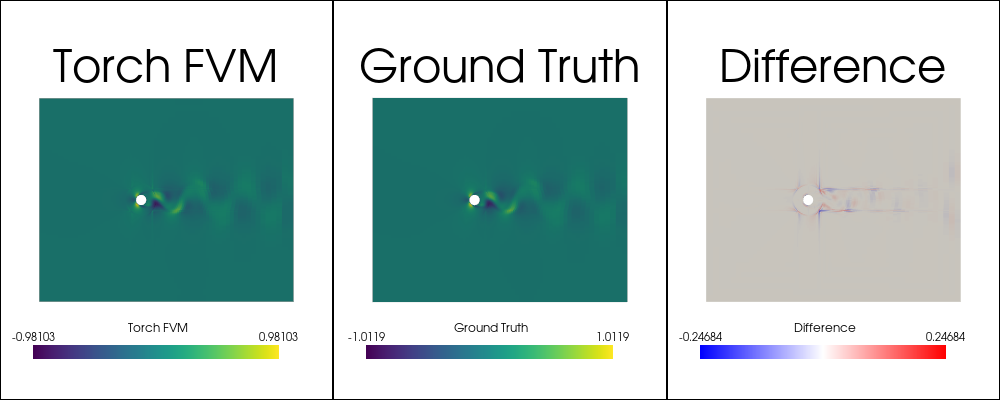

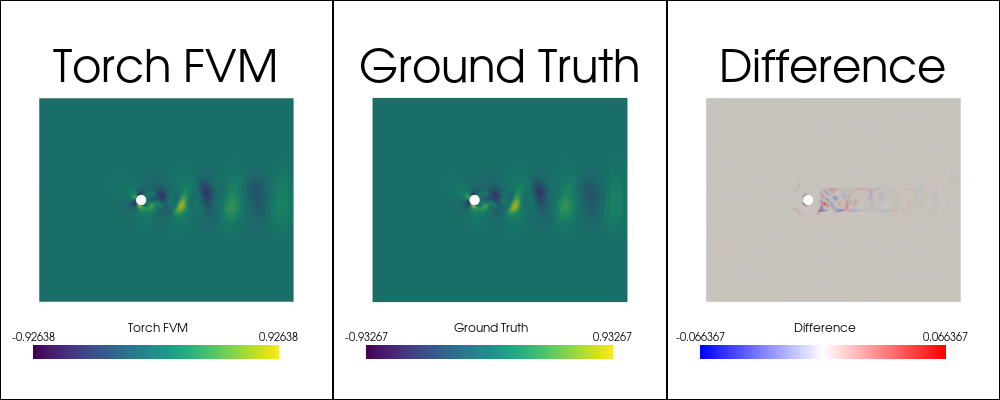

In [44]:
names = ['divU', 'divV']
for i, j in enumerate([0,1]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=divU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = divU_gt.squeeze(0).squeeze(0).numpy(),
                    )

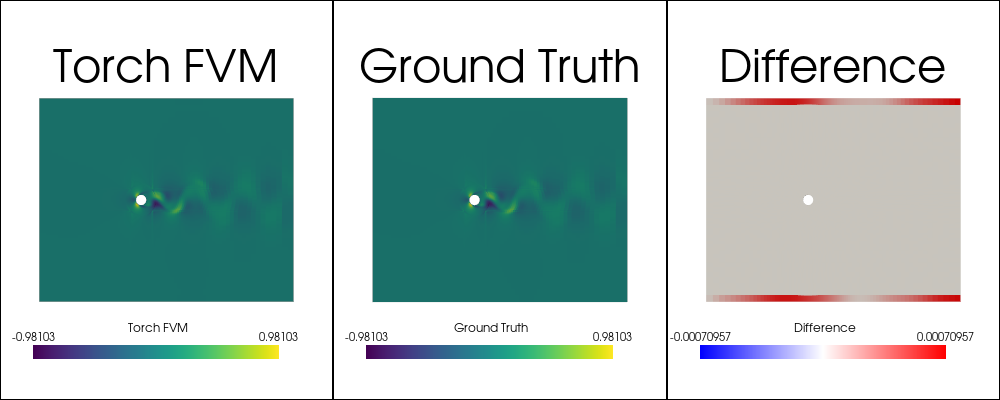

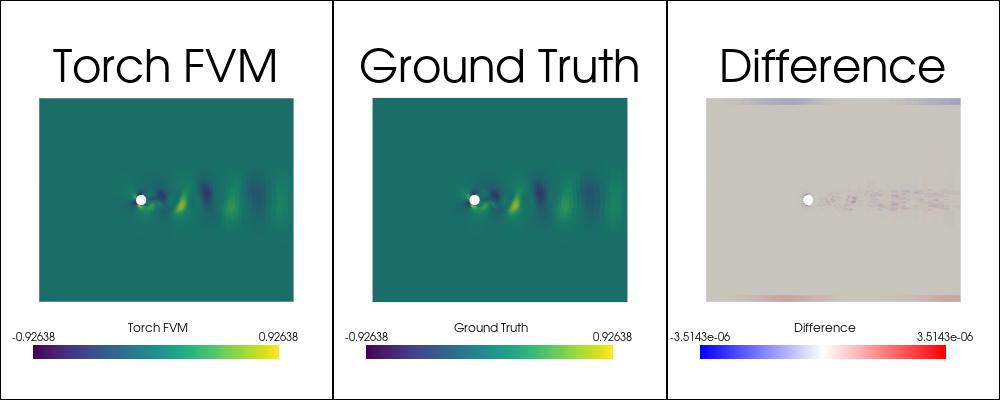

In [45]:
divU_gt_uncorrected = torch.tensor(vtk_mesh['divU_phiAll'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
names = ['divU', 'divV']
for i, j in enumerate([0,1]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=divU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = divU_gt_uncorrected.squeeze(0).squeeze(0).numpy(),
                    )

### Laplacian

Laplacian has two methods of calculation, corrected and uncorrected. Both methods use the under-relaxed vector discretization.

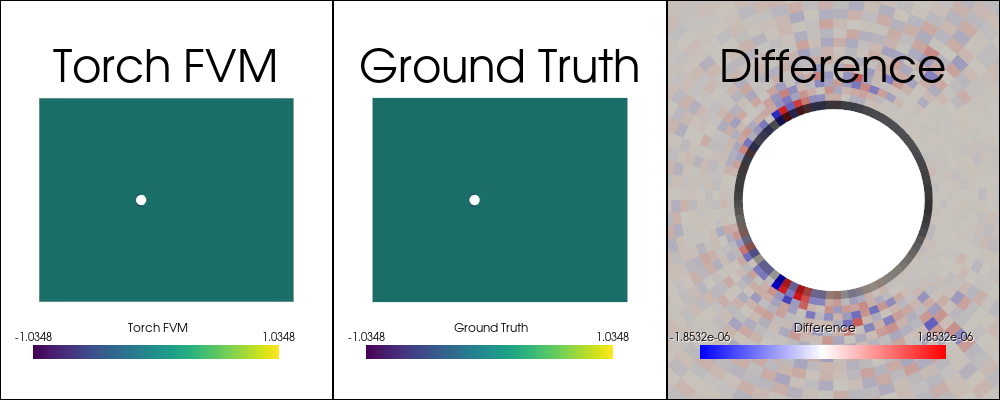

In [46]:
names = ['lapU', 'lapV']
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=lap_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = lapU_gt.squeeze(0).squeeze(0).numpy(),
                    zoom=True
                    )

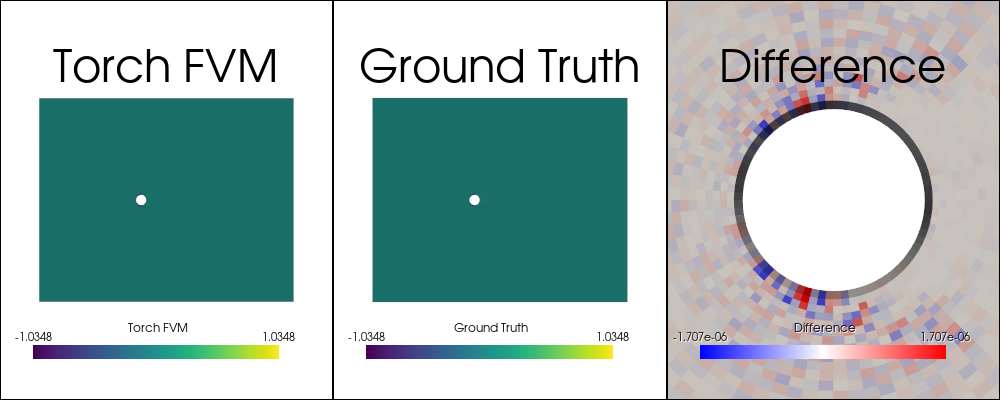

In [47]:
names = ['lapU', 'lapV']
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=lap_pred_corrected.squeeze(0).squeeze(0).numpy(),
                    ground_truth = lapU_gt_corrected.squeeze(0).squeeze(0).numpy(),
                    zoom=True
                    )

### Pressure Gradient

In [49]:
p = torch.tensor(Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\p'), dtype=dtype).unsqueeze(0).unsqueeze(0).unsqueeze(-1)
grad_p = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\grad(p)')

In [ ]:
class Divergence_Operator():
    
    @staticmethod
    def caclulate(self, field: torch.Tensor, field_type:str = 'U') -> torch.Tensor:
        batch_size = field.shape[0]
        time_size = field.shape[1]
        channel_size = field.shape[-1]

        div_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, self.mesh.dim), dtype=field.dtype, device=self.device)
        grad_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, self.mesh.dim, channel_size), dtype=field.dtype, device=self.device)
        
        div_field, grad_field = Divergence_Operator.internal_flux(self, div_field, grad_field, field)
        div_field, grad_field = Divergence_Operator.boundary_flux(self, div_field, grad_field, field, field_type)
        div_field/= self.mesh.cell_volumes.reshape(1,1,-1,1)
        grad_field/= self.mesh.cell_volumes.reshape(1,1,-1,1,1)
        return div_field, grad_field.flatten(start_dim=-2)

    def internal_flux(self, div_field:torch.tensor, grad_field:torch.tensor, field:torch.tensor) -> torch.Tensor:
        face_values = interpolate_to_faces(self, field)
        idx = self.mesh.internal_faces
        divergence = torch.einsum('btfd,fd->btf', face_values, self.mesh.face_areas[idx]).unsqueeze(-1) * face_values
        gradient = torch.einsum('btfd,fe->btfed', face_values, self.mesh.face_areas[idx])
        print(face_values.shape, gradient.shape, grad_field.shape)
        div_field.index_add_(2, self.mesh.face_owners[idx], divergence)
        div_field.index_add_(2, self.mesh.face_neighbors[idx], -divergence)
        print(gradient.shape, grad_field.shape)
        grad_field.index_add_(2, self.mesh.face_owners[idx], gradient)
        grad_field.index_add_(2, self.mesh.face_neighbors[idx], -gradient)
        return div_field, grad_field
    
    @staticmethod
    def boundary_flux(self, div_field:torch.tensor, grad_field:torch.tensor, field:torch.tensor, field_type:str='U') -> torch.Tensor:
        batch_size = field.shape[0]
        time_size = field.shape[1]
        channel_size = field.shape[-1]

        for patch_name, patch_faces in self.mesh.patch_face_keys.items():
            patch_type = self.bc_conditions[field_type][patch_name]['type']
            
            if patch_type in ('empty','noSlip'):
                continue
            if patch_type == 'fixedValue':
                field_value = torch.tensor(self.bc_conditions[field_type][patch_name]['value'], dtype=self.dtype, device=self.device)
                face_values = field_value.reshape(1, 1, 1, -1).repeat(batch_size, time_size, len(patch_faces), 1)
            elif patch_type == 'symmetryPlane':
                face_values = field[...,self.mesh.face_owners[patch_faces],:] - 2*(torch.einsum('btfc,fc->btf', 
                                                                                                field[...,self.mesh.face_owners[patch_faces],:], 
                                                                                                self.mesh.face_normal_unit_vectors[patch_faces,:]
                                                                                                )).unsqueeze(-1) * self.mesh.face_normal_unit_vectors[patch_faces,:].unsqueeze(0)
            elif patch_type == 'zeroGradient':
                face_values = field[...,self.mesh.face_owners[patch_faces],:]
            else:
                raise NotImplementedError(f'patch type {patch_type} not implemented')
            
            divergence = torch.einsum('btfd,fd->btf', face_values, self.mesh.face_areas[patch_faces]).unsqueeze(-1) * face_values
            gradient = torch.einsum('btfd,fe->btfed', face_values, self.mesh.face_areas[patch_faces])
            
            if patch_type == 'symmetryPlane' and channel_size ==1:  # i.e. Scalar
                gradient = torch.zeros(batch_size, time_size, len(patch_faces), 1, dtype=self.dtype)

            div_field.index_add_(2, self.mesh.face_owners[patch_faces], divergence)
            grad_field.index_add_(2, self.mesh.face_owners[patch_faces], gradient)
    
        return div_field, grad_field

In [41]:
_, gradient_p = Divergence_Operator.caclulate(mesh, p, field_type='p')

torch.Size([1, 1, 18180, 1]) torch.Size([1, 1, 18180, 3, 1]) torch.Size([1, 1, 9200, 3, 1])
torch.Size([1, 1, 18180, 3, 1]) torch.Size([1, 1, 9200, 3, 1])
out
sym1
sym2
in
cylinder


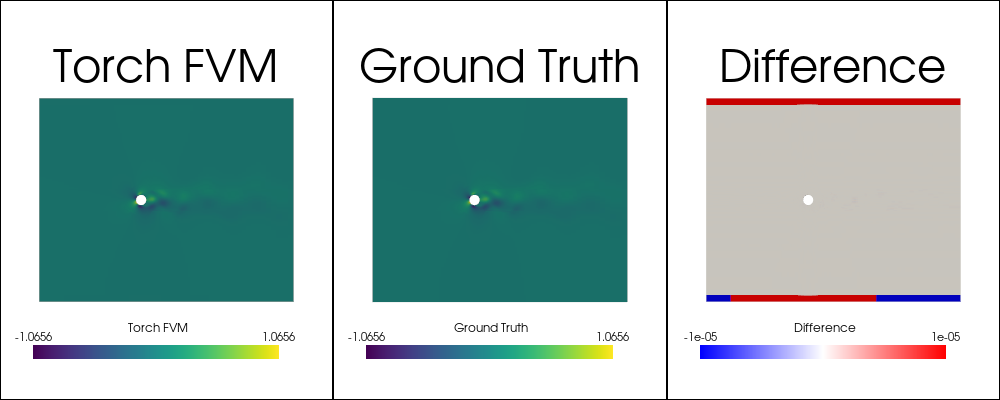

In [54]:
plot_comparison(vtk_mesh, None, f'None',i=1, interactive = True, point_label=False,
                    prediction=gradient_p[0,0,...].numpy(),
                    ground_truth = grad_p,
                    clims3=[-0.00001,0.00001],
                    zoom=False
                    )